## Please provide your inputs as followed:

- **input_sdate**: The start date of your period of interest in the format **dd-mm-YYYY**
- **input_edate**: The end date of your period of interestin the format **dd-mm-YYYY**
- **geometry**: The region of interest. Please provide this in a **bounding box format** (e.g. [10, -5, 25, 20])

In [122]:
start_date = "2023 08 20"
end_date = "2023 08 25"
region = "Australia"

## Library imports 

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import fsspec
import numpy as np
import xarray as xr
import planetary_computer
import pystac_client
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, time
import json
import stackstac

## Starting up PySTAC client

In [5]:
# Initialize PySTAC client for data query
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

## User Input

### Processing of user input

In [123]:
# Function to convert date format 
def convert_format_date(input_date):
    correct_formats = ["%d %m %Y", "%Y %m %d", "%d/%m/%Y", "%Y/%m/%d", "%d-%m-%Y", "%Y-%m-%d"]
    
    for format_str in correct_formats:
        try:
            date_obj = datetime.strptime(input_date, format_str)
            formatted_date = date_obj.strftime("%Y-%m-%d")
            return formatted_date
        except ValueError: # Raised if input format is not compatible with set standard 
            pass
    
    raise ValueError("Invalid data format")

# Convert user start date format
try:
    start_date = convert_format_date(start_date)
except ValueError:
    print("Invalid start date format. Please check the acceptable formats")
            
# Convert user end date format
try:
    end_date = convert_format_date(end_date)
except ValueError:
    print("Invalid end date format. Please check the acceptable formats")

date_period = start_date + "/" + end_date 
print(date_period)

2023-08-20/2023-08-25


In [124]:
date_difference = int(end_date[-2:]) - int(start_date[-2:])
date_difference

5

In [125]:
date_range = np.arange(np.datetime64(start_date), np.datetime64(end_date))
# date_range = [np.datetime64(date, 'ns') for date in date_range]

date_range 

array(['2023-08-20', '2023-08-21', '2023-08-22', '2023-08-23',
       '2023-08-24'], dtype='datetime64[D]')

## Search for product

### Search based on country input

In [126]:
# Get geopandas in-built naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/tmp/ipykernel_403/755612632.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [127]:
ROI = world[world["name"] == region]
ROI_bbox = ROI.total_bounds

In [128]:
def search_catalog(region, date_period):
    search_parameters = {
        "collections": "sentinel-5p-l2-netcdf",
        "datetime": date_period,
        "query": {"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
    }
   
    #bbox input
    if isinstance(region, list) and len(region) == 4:
        min_long, min_lat, max_long, max_lat = region
        #-180 to 180 for longitudes, -90 to 90 for latitudes
        long = all(-180 <= coordinates <= 180 for coordinates in [min_long, max_long]) 
        lat = all(-90 <= coordinates <= 90 for coordinates in [min_lat, max_lat])
        
        if long and lat:
            search_parameters["bbox"] = region
        elif not long:
            raise ValueError("Invalid longitudes in bbox")
        elif not lat:
            raise ValueError("Invalid latitudes in bbox")
        else:
            raise ValueError("Invalid coordinates in bbox")
        
    else:
        if ROI.empty: # Raise error if invalid region input
            raise ValueError("Invalid country name")
        
        gjson = json.loads(ROI.to_json())
        coordinates = gjson["features"][0]["geometry"]["coordinates"]
        
        if not isinstance(coordinates, list): 
            coordinates = [coordinates]    
                         
        #MultiPolygon is used to represent multiple polygons bbox and country     
        search_parameters["intersects"] = {
            "type": "MultiPolygon", 
            "coordinates": coordinates
        }
        
    search = catalog.search(**search_parameters)
    items = search.item_collection()

    return items

# Use search_catalog function with a single variable "region" for bbox and country name
result = search_catalog(region=region, date_period=date_period)

# Print the result
print(f"Number of items for input: {len(result)}")

Number of items for input: 17


## Process queried data into a dataset

In [12]:
item_links = [item.assets['ch4'].href for item in result]
item_links

f = fsspec.open_files(item_links)
f = [file.open() for file in f]

In [13]:
datasets = [xr.open_dataset(nc_file, group="PRODUCT", engine="h5netcdf") for nc_file in f]

In [16]:
dsc = xr.concat(datasets, dim="time")
dsc

<xarray.Dataset>
Dimensions:                              (scanline: 4173, ground_pixel: 215,
                                          corner: 4, layer: 12, level: 13,
                                          time: 17)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
  * time                                 (time) datetime64[ns] 2023-08-25 ......
    latitude                             (time, scanline, ground_pixel) float32 ...
    longitude                            (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                           (time, scanline) datetime64[ns] 2023...
    time_utc                             (time, scanline) object '2023-08-25T...
    qa_value                             (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 ...
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 ...

In [44]:
dsc.latitude[2][4171]

<xarray.DataArray 'latitude' (ground_pixel: 215)>
array([55.725624, 55.88277 , 56.02979 , 56.16777 , 56.297638, 56.42018 ,
       56.536102, 56.645992, 56.75038 , 56.849743, 56.944477, 57.03496 ,
       57.12152 , 57.204445, 57.284004, 57.36044 , 57.43396 , 57.50477 ,
       57.573044, 57.638947, 57.70263 , 57.764225, 57.823868, 57.881668,
       57.937733, 57.992165, 58.04505 , 58.096485, 58.146534, 58.19528 ,
       58.242786, 58.289124, 58.334343, 58.37851 , 58.421665, 58.463867,
       58.505154, 58.545578, 58.58517 , 58.623974, 58.662025, 58.69936 ,
       58.736004, 58.771988, 58.807346, 58.842102, 58.876286, 58.909912,
       58.943012, 58.9756  , 59.00771 , 59.03935 , 59.070538, 59.1013  ,
       59.13165 , 59.161602, 59.191174, 59.22038 , 59.249233, 59.27775 ,
       59.305935, 59.333813, 59.36139 , 59.388676, 59.41568 , 59.44242 ,
       59.468903, 59.495136, 59.52113 , 59.546894, 59.572437, 59.59777 ,
       59.6229  , 59.647827, 59.67257 , 59.69713 , 59.721516, 59.74573 ,
       59.76979 , 59.793694, 59.817448, 59.84106 , 59.86454 , 59.887886,
       59.91111 , 59.934216, 59.957207, 59.980087, 60.00287 , 60.02555 ,
       60.04814 , 60.070644, 60.093063, 60.115406, 60.137672, 60.159874,
       60.182007, 60.204082, 60.2261  , 60.248066, 60.269985, 60.291862,
       60.3137  , 60.335506, 60.35728 , 60.37903 , 60.400757, 60.422462,
       60.444157, 60.465843, 60.487522, 60.509197, 60.530876, 60.552563,
       60.574257, 60.59597 , 60.6177  , 60.639446, 60.661224, 60.683033,
       60.704876, 60.72676 , 60.748684, 60.770657, 60.79268 , 60.81476 ,
       60.8369  , 60.859104, 60.881374, 60.90372 , 60.926144, 60.948647,
       60.971237, 60.99392 , 61.0167  , 61.039577, 61.06256 , 61.085655,
       61.108864, 61.13219 , 61.155647, 61.17923 , 61.20295 , 61.226807,
       61.250813, 61.274967, 61.299282, 61.323757, 61.3484  , 61.373215,
       61.398212, 61.423393, 61.44877 , 61.47434 , 61.500114, 61.5261  ,
       61.552303, 61.578728, 61.605385, 61.63228 , 61.659416, 61.686802,
       61.714447, 61.74236 , 61.770542, 61.799007, 61.827755, 61.856804,
       61.88615 , 61.91581 , 61.94579 , 61.976097, 62.006737, 62.03772 ,
       62.069057, 62.100754, 62.132816, 62.165257, 62.198086, 62.231304,
       62.26493 , 62.29896 , 62.333416, 62.368298, 62.40361 , 62.43937 ,
       62.47558 , 62.51224 , 62.54937 , 62.58697 , 62.625046, 62.6636  ,
       62.70264 , 62.74217 , 62.78218 , 62.822685, 62.863674, 62.905144,
       62.94709 , 62.989502, 63.032368, 63.075672, 63.119385, 63.163486,
       63.20794 , 63.2527  , 63.297718, 63.342926, 63.388245, 63.433582,
       63.478817, 63.523808, 63.56838 , 63.612324, 63.655373],
      dtype=float32)
Coordinates:
    scanline      float64 4.171e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2023-08-25
    latitude      (ground_pixel) float32 55.73 55.88 56.03 ... 63.57 63.61 63.66
    longitude     (ground_pixel) float32 -7.694 -8.217 -8.717 ... -53.12 -53.82
Attributes:
    long_name:      pixel center latitude
    units:          degrees_north
    standard_name:  latitude
    valid_min:      -90.0
    valid_max:      90.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/latitude_bounds

In [18]:
dsc_na = dsc.dropna(dim="scanline", how="any")
dsc_na

<xarray.Dataset>
Dimensions:                              (scanline: 0, ground_pixel: 215,
                                          corner: 4, layer: 12, level: 13,
                                          time: 17)
Coordinates:
  * scanline                             (scanline) float64 
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
  * time                                 (time) datetime64[ns] 2023-08-25 ......
    latitude                             (time, scanline, ground_pixel) float32 
    longitude                            (time, scanline, ground_pixel) float32 
Data variables:
    delta_time                           (time, scanline) datetime64[ns] 
    time_utc                             (time, scanline) object 
    qa_value                             (time, scanline, ground_pixel) float32 
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32

In [45]:
d = xr.open_mfdataset(f, group="PRODUCT", engine="h5netcdf", combine='by_coords') 
d

<xarray.Dataset>
Dimensions:                              (scanline: 4173, ground_pixel: 215,
                                          corner: 4, layer: 12, level: 13,
                                          time: 6)
Coordinates:
  * scanline                             (scanline) float64 0.0 ... 4.172e+03
  * ground_pixel                         (ground_pixel) float64 0.0 ... 214.0
  * corner                               (corner) float64 0.0 1.0 2.0 3.0
  * layer                                (layer) float64 0.0 1.0 ... 10.0 11.0
  * level                                (level) float64 0.0 1.0 ... 11.0 12.0
  * time                                 (time) datetime64[ns] 2023-08-20 ......
    latitude                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    longitude                            (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
Data variables:
    delta_time                           (time, scanline) datetime64[ns] dask.array<chunksize=(1, 4173), meta=np.ndarray>
    time_utc                             (time, scanline) object dask.array<chunksize=(1, 4173), meta=np.ndarray>
    qa_value                             (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio                 (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio_precision       (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>
    methane_mixing_ratio_bias_corrected  (time, scanline, ground_pixel) float32 dask.array<chunksize=(1, 4173, 215), meta=np.ndarray>

In [20]:
dscd = dsc.methane_mixing_ratio[dsc.time == date_range[1]]
dscd = [da for da in dscd]
dscd[0]

<xarray.DataArray 'methane_mixing_ratio' (scanline: 4173, ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2023-08-21
    latitude      (scanline, ground_pixel) float32 -86.02 -86.33 ... nan nan
    longitude     (scanline, ground_pixel) float32 30.11 32.41 34.98 ... nan nan
Attributes:
    units:                1e-9
    standard_name:        dry_atmosphere_mole_fraction_of_methane
    long_name:            column averaged dry air mixing ratio of methane
    ancillary_variables:  methane_mixing_ratio_precision column_averaging_ker...

In [21]:
# dscd[1] = dscd[1].latitude.dropna(dim="scanline", how="any")
dscd[1]

<xarray.DataArray 'methane_mixing_ratio' (scanline: 4173, ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2023-08-21
    latitude      (scanline, ground_pixel) float32 -86.01 -86.32 ... nan nan
    longitude     (scanline, ground_pixel) float32 56.11 58.46 61.08 ... nan nan
Attributes:
    units:                1e-9
    standard_name:        dry_atmosphere_mole_fraction_of_methane
    long_name:            column averaged dry air mixing ratio of methane
    ancillary_variables:  methane_mixing_ratio_precision column_averaging_ker...

In [22]:
# dscd[2] = dscd[2].dropna(dim="scanline", how="any")
dscd[2]

<xarray.DataArray 'methane_mixing_ratio' (scanline: 4173, ground_pixel: 215)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 0.0 1.0 2.0 ... 4.171e+03 4.172e+03
  * ground_pixel  (ground_pixel) float64 0.0 1.0 2.0 3.0 ... 212.0 213.0 214.0
    time          datetime64[ns] 2023-08-21
    latitude      (scanline, ground_pixel) float32 -86.0 -86.31 ... nan nan
    longitude     (scanline, ground_pixel) float32 81.75 84.12 86.75 ... nan nan
Attributes:
    units:                1e-9
    standard_name:        dry_atmosphere_mole_fraction_of_methane
    long_name:            column averaged dry air mixing ratio of methane
    ancillary_variables:  methane_mixing_ratio_precision column_averaging_ker...

In [23]:
dsc.stack(
    dim=
)

SyntaxError: invalid syntax (954765082.py, line 3)

In [72]:
lat.shape

(4173, 215)

In [73]:
lon.shape

(4173, 215)

In [74]:
data.shape

(4173, 215)

In [78]:
# Extract the relevant data (assuming the variable name is 'methane_mixing_ratio_bias_corrected')
data = d.methane_mixing_ratio_bias_corrected[d.time == date_range[0]].values.squeeze() #print(data.values)
lon = d.longitude[d.time == date_range[0]].values.squeeze()
lat = d.latitude[d.time == date_range[0]].values.squeeze()

# Calculate vmin and vmax for color normalization
vmin, vmax = np.nanpercentile(data, [1, 99])

# Plot the data
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

NameError: name 'bbox' is not defined

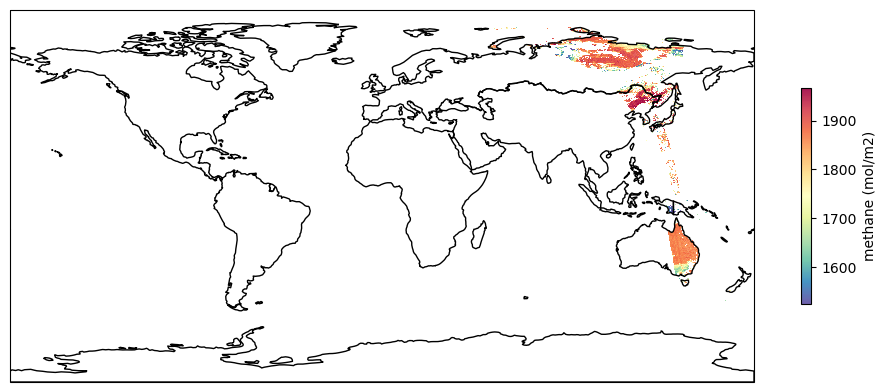

In [80]:
# Initialize the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
continent_borders = world.dissolve(by='continent')
continent_borders.boundary.plot(ax=ax, linewidth=1, color='black')

colormesh = ax.pcolormesh(lon, lat, data, cmap="Spectral_r", norm=norm, transform=ccrs.PlateCarree(), alpha=0.9, rasterized=True)
        
fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="methane (mol/m2)")

ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

plt.show()

In [ ]:
# Extract the relevant data (assuming the variable name is 'methane_mixing_ratio_bias_corrected')
data = dsc.methane_mixing_ratio_bias_corrected.values #print(data.values)
lon = dsc.longitude.values.squeeze()
lat = dsc.latitude.values.squeeze()

# Calculate vmin and vmax for color normalization
vmin, vmax = np.nanpercentile(data, [1, 99])

# Plot the data
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

In [ ]:
# Initialize the map
fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
continent_borders = world.dissolve(by='continent')
continent_borders.boundary.plot(ax=ax, linewidth=1, color='black')

colormesh = ax.pcolormesh(lon, lat, data.values, cmap="Spectral", norm=norm, transform=ccrs.PlateCarree(), alpha=0.9, rasterized=True)
        
fig.colorbar(colormesh, pad=0.05, shrink=0.35, label="methane (mol/m2)")

ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

plt.show()

## Plot Time Series